In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import os


In [3]:
customers = pd.read_csv('./data/Customers.csv')
products = pd.read_csv('./data/Products.csv')
transactions = pd.read_csv('./data/Transactions.csv')

transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'], errors='coerce')
transactions.dropna(subset=['TransactionDate'], inplace=True)


In [4]:
data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

customer_features = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'ProductName': lambda x: ' '.join(x)
}).reset_index()

scaler = MinMaxScaler()
customer_features[['TotalValue', 'Quantity']] = scaler.fit_transform(customer_features[['TotalValue', 'Quantity']])


In [5]:
vectorizer = TfidfVectorizer()
product_vectors = vectorizer.fit_transform(customer_features['ProductName'])

combined_features = pd.concat(
    [
        pd.DataFrame(product_vectors.toarray(), index=customer_features['CustomerID']),
        customer_features[['TotalValue', 'Quantity']].set_index(customer_features['CustomerID'])
    ],
    axis=1
)

similarity_matrix = cosine_similarity(combined_features)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features['CustomerID'], columns=customer_features['CustomerID'])


In [6]:
lookalike_map = {}

for customer_id in customer_features['CustomerID']:
    similar_customers = (
        similarity_df[customer_id]
        .sort_values(ascending=False)
        .iloc[1:4]
    )
    lookalike_map[customer_id] = list(similar_customers.items())


In [22]:
lookalike_data = []

for cust_id, similar_custs in lookalike_map.items():
    for similar_cust_id, score in similar_custs:
        lookalike_data.append({
            'cust_id': cust_id,
            'similar_cust_id': similar_cust_id,
            'similarity_score': score
        })

lookalike_df = pd.DataFrame(lookalike_data)
lookalike_df.to_csv('Souvik_Mahanta_Lookalike.csv', index=False)

print("Lookalike.csv created successfully.")


Lookalike.csv created successfully.


In [10]:
filtered_recommendations = lookalike_df[lookalike_df['cust_id'].isin([f'C{i:04d}' for i in range(1, 21)])]
print(filtered_recommendations)


   cust_id similar_cust_id  similarity_score
0    C0001           C0197          0.831755
1    C0001           C0026          0.785355
2    C0001           C0100          0.760113
3    C0002           C0133          0.894158
4    C0002           C0173          0.759703
5    C0002           C0164          0.694790
6    C0003           C0164          0.762306
7    C0003           C0181          0.720761
8    C0003           C0046          0.693690
9    C0004           C0075          0.842351
10   C0004           C0008          0.824389
11   C0004           C0065          0.798197
12   C0005           C0128          0.754456
13   C0005           C0096          0.731486
14   C0005           C0014          0.727300
15   C0006           C0187          0.808634
16   C0006           C0191          0.730472
17   C0006           C0139          0.708227
18   C0007           C0181          0.764157
19   C0007           C0031          0.714033
20   C0007           C0118          0.697924
21   C0008

Similarity DataFrame Columns: Index(['cust_id', 'similar_cust_id', 'similarity_score'], dtype='object')
Customers DataFrame Columns: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Precision: 0.12352941176470589
Recall: 0.9264705882352942


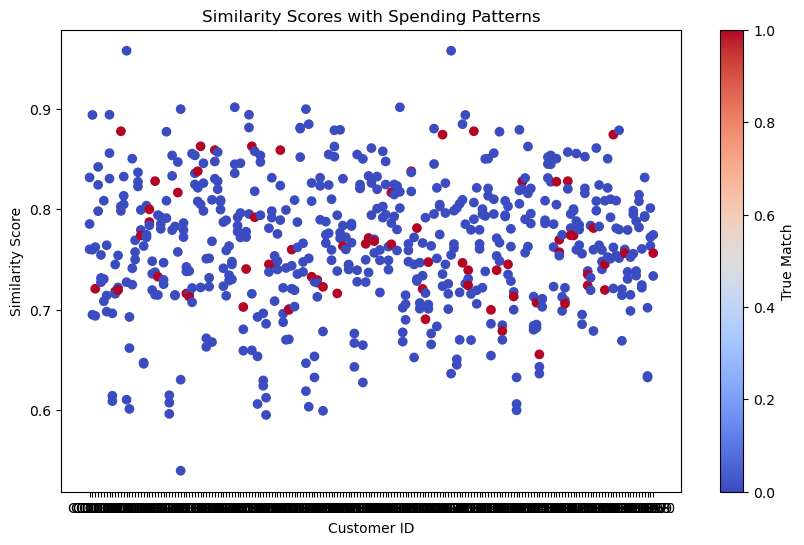

High similarity outliers (score > 0.9):
    cust_id similar_cust_id  similarity_score CustomerID_cust  spending_cust  \
39    C0014           C0128          0.958256           C0014     512.457559   
153   C0052           C0110          0.901838           C0052     188.139030   
327   C0110           C0052          0.901838           C0110     416.929489   
381   C0128           C0014          0.958256           C0128     393.630045   

     purchase_frequency_cust  region_code_cust CustomerID_similar  \
39                         2                 1              C0128   
153                        6                 3              C0110   
327                        3                 0              C0052   
381                        4                 0              C0014   

     spending_similar  purchase_frequency_similar  region_code_similar  \
39         393.630045                           4                    0   
153        416.929489                           3                

D:\ANACONDA\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


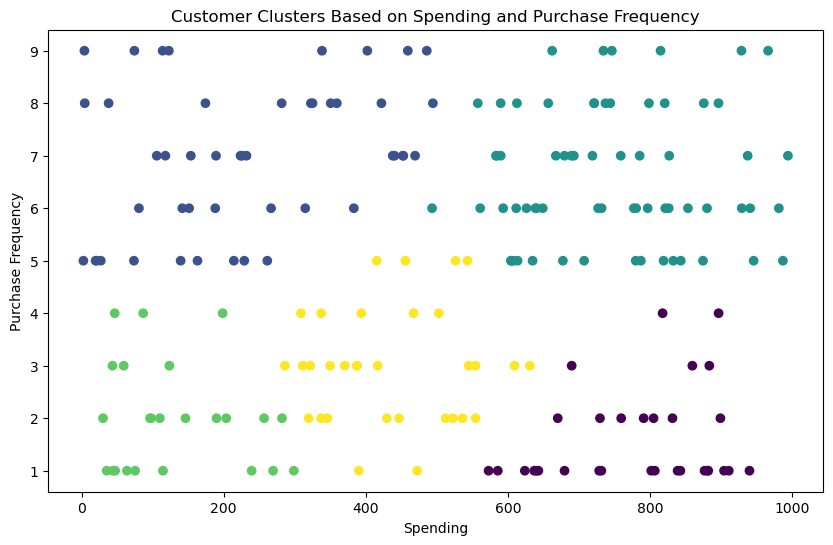

Top 3 recommendations with true matches: 68 out of 597


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

similarity_df = pd.read_csv('Souvik_Mahanta_Lookalike.csv')
customers_df = pd.read_csv('./data/Customers.csv')

print("Similarity DataFrame Columns:", similarity_df.columns)
print("Customers DataFrame Columns:", customers_df.columns)

customers_df['spending'] = np.random.rand(len(customers_df)) * 1000
customers_df['purchase_frequency'] = np.random.randint(1, 10, size=len(customers_df))
customers_df['region_code'] = customers_df['Region'].astype('category').cat.codes

merged_df = similarity_df.merge(customers_df[['CustomerID', 'spending', 'purchase_frequency', 'region_code']], 
                                 left_on='cust_id', right_on='CustomerID', how='left')
merged_df = merged_df.merge(customers_df[['CustomerID', 'spending', 'purchase_frequency', 'region_code']], 
                             left_on='similar_cust_id', right_on='CustomerID', suffixes=('_cust', '_similar'), how='left')

merged_df['true_match'] = (abs(merged_df['spending_cust'] - merged_df['spending_similar']) < 200) & \
                           (abs(merged_df['purchase_frequency_cust'] - merged_df['purchase_frequency_similar']) < 2)

threshold = 0.7
merged_df['predicted_match'] = (merged_df['similarity_score'] > threshold).astype(int)

y_true = merged_df['true_match']
y_pred = merged_df['predicted_match']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

plt.figure(figsize=(10,6))
plt.scatter(merged_df['cust_id'], merged_df['similarity_score'], c=merged_df['true_match'], cmap='coolwarm')
plt.title('Similarity Scores with Spending Patterns')
plt.xlabel('Customer ID')
plt.ylabel('Similarity Score')
plt.colorbar(label='True Match')
plt.show()

high_similarity_outliers = merged_df[merged_df['similarity_score'] > 0.9]
low_similarity_outliers = merged_df[merged_df['similarity_score'] < 0.2]

print("High similarity outliers (score > 0.9):")
print(high_similarity_outliers)
print("\nLow similarity outliers (score < 0.2):")
print(low_similarity_outliers)

scaler = StandardScaler()
customers_df_scaled = scaler.fit_transform(customers_df[['spending', 'purchase_frequency']])

kmeans = KMeans(n_clusters=5)
customers_df['cluster'] = kmeans.fit_predict(customers_df_scaled)

plt.figure(figsize=(10,6))
plt.scatter(customers_df['spending'], customers_df['purchase_frequency'], c=customers_df['cluster'], cmap='viridis')
plt.title('Customer Clusters Based on Spending and Purchase Frequency')
plt.xlabel('Spending')
plt.ylabel('Purchase Frequency')
plt.show()

top_3 = merged_df.groupby('cust_id').apply(lambda x: x.nlargest(3, 'similarity_score'))

top_3_correct = top_3[top_3['true_match'] == 1]

print(f"Top 3 recommendations with true matches: {len(top_3_correct)} out of {len(top_3)}")
